In [15]:
from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
from matplotlib import pyplot
from mlxtend.feature_selection import SequentialFeatureSelector as sfbs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfbs
from numpy import *
from numpy import absolute
from numpy import arange
from numpy import mean
from numpy import std
from numpy.random import seed
from pandas import read_csv
from random import randint
from random import random
from random import seed
from scipy import stats # For in-built method to get PCC
from sklearn import linear_model
from sklearn.datasets import load_boston
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RepeatedKFold, train_test_split

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import sklearn
from sklearn.preprocessing import *

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from statsmodels.stats.outliers_influence import OLSInfluence
from tqdm import tnrange, tqdm_notebook
from zca import zca
import itertools
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import pandas as pd
import pingouin as pg
import scipy
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
import statsmodels.tools
import sys

#if not sys.warnoptions:
#    import warnings
#    warnings.simplefilter("ignore")
#import random
import warnings
warnings.filterwarnings('ignore')

zca = zca.ZCA()

In [16]:
class ss_yj_Transformer(BaseEstimator, TransformerMixin):
    # add another additional parameter, just for fun, while we are at it
    
    def __init__(self, feature_names=[], additional_param = ""):  
        #print('\n>>>>>>>init() called.\n')
        self.ss = StandardScaler()
        self.pt = PowerTransformer(standardize=True)
        self.feature_names = feature_names
        self.additional_param = additional_param

    def fit(self, X, y = None):
        self.ss.fit(X)
        self.pt.fit(self.ss.transform(X))
        return self

    def transform(self, X, y = None):
        pt_X_ = pd.DataFrame(self.pt.fit(pd.DataFrame(self.ss.fit(X).transform(X),index=X.index,columns=X.columns)).transform(pd.DataFrame(self.ss.fit(X).transform(X),index=X.index,columns=X.columns)),index=X.index,columns=X.columns)
        return pt_X_

    def inverse_transform(self, target):
        target_ = pd.DataFrame(self.ss.inverse_transform(self.pt.inverse_transform(target)),index=target.index,columns=target.columns)
        return target_

In [17]:
numCV = 5
kfold = KFold(n_splits=numCV, shuffle=True)
p_threshold = .05
divisor = .2
target = 'Poverty'
exclude = 'States'

cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)

alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
l1s = arange(0, 1, 0.01/divisor)

seed_ = 3

#random.seed(11)

seed(seed_)

In [18]:
# evaluate a model
def evaluate_model(X, y, model):
	# define model evaluation method
	cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# force scores to be positive
	return absolute(scores)

# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, model):
	# fut the model on all data
	model.fit(X, y)
	# plot the dataset
	pyplot.scatter(X, y)
	# plot the line of best fit
	xaxis = arange(X.min(), X.max(), 0.01)
	yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
	pyplot.plot(xaxis, yaxis, color='r')
	# show the plot
	pyplot.title(type(model).__name__)
	pyplot.show()

In [19]:
all_data = pd.read_csv('../data/raw/states.csv')

In [20]:
train, valid = train_test_split(all_data.index, test_size=0.3, shuffle=True)
valid, test = train_test_split(valid,  test_size=0.5, shuffle=True)

X = all_data[set(all_data.columns).difference([target,exclude])].copy()
y = pd.DataFrame(all_data[target].copy())

X_train = X.loc[train].copy()

X_train_ss_yj_t = ss_yj_Transformer()
X_train_ss_yj_t.fit(X_train)
X_train_ss_yj = X_train_ss_yj_t.transform(X_train)

X_valid = X.loc[valid].copy()

X_test = X.loc[test].copy()

y_train = y.loc[X_train.index][[target]].copy()
y_valid = y.loc[X_valid.index][[target]].copy()
y_test = y.loc[X_test.index][[target]].copy()

y_train_ss_yj_t = ss_yj_Transformer()
y_train_ss_yj_t.fit(y_train)
y_train_ss_yj = y_train_ss_yj_t.transform(y_train)

x_valid_ss_yj = X_train_ss_yj_t.transform(X_valid)

In [21]:
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

x_train_ss_yj_inter = pd.DataFrame(interaction.fit_transform(X_train_ss_yj),index=X_train_ss_yj.index,columns=interaction.get_feature_names(input_features=X_train_ss_yj.columns))

x_valid_ss_yj_inter = pd.DataFrame(interaction.fit_transform(x_valid_ss_yj),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))

In [22]:
lr = LinearRegression()

#backwards step subset
sfbs1 = sfbs(lr, 
          k_features=len(x_train_ss_yj_inter.columns), 
          #forward=True, 
          floating=True, 
          scoring='neg_mean_squared_error',
          #scoring='accuracy',
          n_jobs=-1,
          cv=numCV)
            
sfbs1 = sfbs1.fit(x_train_ss_yj_inter, y_train_ss_yj)


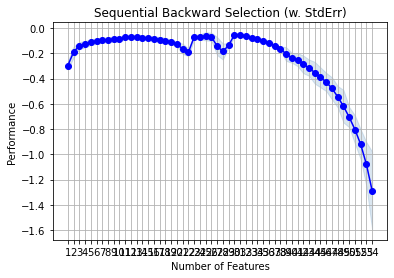

In [23]:
fig = plot_sfbs(sfbs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

In [24]:
features = list(pd.DataFrame(sfbs1.subsets_).loc['feature_names'].values)

In [25]:
ss_position = np.array(pd.DataFrame(pd.DataFrame(sfbs1.subsets_)).loc['avg_score']).argmax()

In [26]:
ss_position_parse = list((pd.DataFrame(sfbs1.subsets_)).T[(pd.DataFrame(sfbs1.subsets_)).T['avg_score']>=np.max(np.array(pd.DataFrame(pd.DataFrame(sfbs1.subsets_)).loc['avg_score']))-np.std(np.array(pd.DataFrame(pd.DataFrame(sfbs1.subsets_)).loc['avg_score']))]['feature_names'].iloc[0])

In [27]:
ss_sortedFeatures = list(np.array(pd.DataFrame(sfbs1.subsets_).loc['feature_names'])[ss_position])

In [28]:
CV_results = pd.DataFrame()#[]#np.zeros(shape=(len(features),5))

#looping over sequentially selected features, deriving ElasticNet hyper parm's over each best subset and noting error

for f in features:

    print(f)
    cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)

    EN_CV = ElasticNetCV(l1_ratio=l1s, alphas=alphas, cv=cv, n_jobs=-1)
    # fit model

    X_subset = pd.DataFrame(x_train_ss_yj_inter[list(np.asarray(f))])
    y_ = y_train_ss_yj
    EN_CV.fit(X_subset, y_)
    
    print('alpha: %f' % EN_CV.alpha_)
    print('l1_ratio_: %f' % EN_CV.l1_ratio_)
    
    # evaluate model
    scores = cross_val_score(EN_CV, X_subset, y_, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force scores to be positive
    scores = absolute(scores)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    
    temp = pd.concat([pd.DataFrame({"features": [np.array(f)]}),pd.DataFrame(np.array(mean(scores)).reshape(-1,1)),pd.DataFrame(np.array(std(scores)).reshape(-1,1)),pd.DataFrame(np.array(EN_CV.alpha_).reshape(-1,1)),pd.DataFrame(np.array(EN_CV.l1_ratio_).reshape(-1,1))],axis=1)
    
    CV_results = pd.concat([CV_results,temp],axis=0)

('Income',)
alpha: 0.001000
l1_ratio_: 0.000000
Mean MAE: 0.465 (0.162)
('White', 'Income')
alpha: 0.000000
l1_ratio_: 0.000000
Mean MAE: 0.372 (0.071)
('White', 'Population', 'Income')
alpha: 0.000000
l1_ratio_: 0.900000
Mean MAE: 0.335 (0.042)
('White', 'Population', 'Income', 'Crime Doctors')
alpha: 0.000000
l1_ratio_: 0.250000
Mean MAE: 0.326 (0.045)
('White', 'Population', 'Income', 'Unemployed University', 'Crime Doctors')
alpha: 0.000000
l1_ratio_: 0.600000
Mean MAE: 0.292 (0.055)
('White', 'Population', 'Income', 'Traf Deaths^2', 'Unemployed University', 'Crime Doctors')
alpha: 0.000000
l1_ratio_: 0.150000
Mean MAE: 0.259 (0.052)
('White', 'Population', 'Income', 'Traf Deaths^2', 'Traf Deaths Infant Mort', 'Unemployed University', 'Crime Doctors')
alpha: 0.010000
l1_ratio_: 0.400000
Mean MAE: 0.262 (0.065)
('White', 'Population', 'Income', 'Population Doctors', 'Traf Deaths^2', 'Traf Deaths Infant Mort', 'Unemployed University', 'Crime Doctors')
alpha: 0.010000
l1_ratio_: 0.350

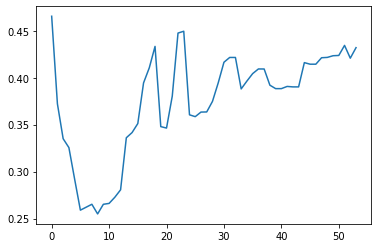

['White' 'Population' 'Income' 'Population Infant Mort'
 'Population Doctors' 'Traf Deaths^2' 'Traf Deaths Infant Mort'
 'Unemployed University' 'Crime Doctors']
['White' 'Population' 'Income' 'Unemployed University' 'Crime Doctors']


,features,mean error,std,alpha,lambda
0,[Income],0.465419,0.161958,0.0010,0.00
1,"[White, Income]",0.372176,0.071435,0.0000,0.00
2,"[White, Population, Income]",0.334989,0.041830,0.0000,0.90
3,"[White, Population, Income, Crime Doctors]",0.325525,0.044530,0.0000,0.25
4,"[White, Population, Income, Unemployed Univers...",0.291896,0.054960,0.0000,0.60
5,"[White, Population, Income, Traf Deaths^2, Une...",0.258906,0.052490,0.0000,0.15
6,"[White, Population, Income, Traf Deaths^2, Tra...",0.262026,0.064627,0.0100,0.40
7,"[White, Population, Income, Population Doctors...",0.265160,0.058161,0.0100,0.35
8,"[White, Population, Income, Population Infant ...",0.254894,0.059228,0.0100,0.65
9,"[White, Population, Income, Population Infant ...",0.265141,0.038973,0.0100,0.70


In [29]:
CV_results.columns = ['features','mean error','std','alpha','lambda']
CV_results.index = np.array(range(0,len(features)))#range(1,len(features)+1)
plt.plot(CV_results['mean error'])
plt.show()

best = CV_results.iloc[CV_results['mean error'].idxmin()]
print(best.loc['features'])

parse = CV_results[CV_results['mean error']<=(np.min(CV_results['mean error'])+np.std(CV_results['mean error']))].iloc[0]
print(parse.loc['features'])
display(CV_results)

In [30]:
model_ss = LinearRegression()
model_ss_parse = LinearRegression()
model_ep = ElasticNet(alpha=parse['alpha'], l1_ratio=parse['lambda'])
model_eb = ElasticNet(alpha=best['alpha'], l1_ratio=best['lambda'])

model_ss.fit(x_train_ss_yj_inter[ss_sortedFeatures], y_train_ss_yj)
model_ss_parse.fit(x_train_ss_yj_inter[ss_position_parse], y_train_ss_yj)
model_ep.fit(x_train_ss_yj_inter[parse['features']],y_train_ss_yj)
model_eb.fit(x_train_ss_yj_inter[best['features']],y_train_ss_yj)

ElasticNet(alpha=0.01, l1_ratio=0.6499999999999999)

In [31]:
zca_X_train = pd.DataFrame(zca.fit_transform(x_train_ss_yj_inter[ss_position_parse]),columns=ss_position_parse,index=x_train_ss_yj_inter.index)
zca_X_train.index = x_train_ss_yj_inter.index
#zca_data = pd.concat([y_train_ss_yj,zca_X_train],axis=1)
#zca_data.index = x_train_ss_yj_inter.index

In [32]:
pca_X_train = PCA(n_components=0.99, svd_solver='full')
pca_X_train.fit(x_train_ss_yj_inter[ss_sortedFeatures])
X_pca_train = pd.DataFrame(pca_X_train.transform(x_train_ss_yj_inter[ss_sortedFeatures]),index = x_train_ss_yj_inter.index)

In [33]:
#zca_data.pcorr()

In [34]:
#sns.pairplot(zca_data,kind="reg", plot_kws={'line_kws':{'color':'red'}})

In [35]:
pca_X_train.explained_variance_ratio_.cumsum()

array([0.21016221, 0.36125413, 0.46519519, 0.56232478, 0.65085082,
       0.71068746, 0.76587436, 0.80556197, 0.84047794, 0.87211327,
       0.90137162, 0.92078796, 0.93863256, 0.9527722 , 0.96230793,
       0.97023495, 0.97712055, 0.98315733, 0.98666335, 0.99003154])

In [36]:
len(ss_sortedFeatures)

31

In [37]:
print(ss_position_parse)

['Income']


In [38]:
#model = sklearn.linear_model.LinearRegression()
#data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
data_set_wConstant_parse_zca = statsmodels.tools.tools.add_constant(zca_X_train)
#y_ = data_set_wConstant[target]
#data_set_wConstant = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model_parse = sm.OLS(y_train_ss_yj,data_set_wConstant_parse_zca)
results_parse = model_parse.fit()
fitted_parse = results_parse.predict(data_set_wConstant_parse_zca)
results_parse.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Poverty   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     82.45
Date:                Sat, 21 Aug 2021   Prob (F-statistic):           1.71e-10
Time:                        12:23:56   Log-Likelihood:                -27.747
No. Observations:                  35   AIC:                             59.49
Df Residuals:                      33   BIC:                             62.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.245e-17      0.093  -6.71e-16      1.000      -0.189       0.189
Income        -0.8574      0.094     -9.080      0.000      -1.050      -0.665
==============================================================================
Omnibus:                        0.411   Durbin-Watson:                   2.610
Prob(Omnibus):                  0.814   Jarque-Bera (JB):                0.556
Skew:                           0.069   Prob(JB):                        0.757
Kurtosis:                       2.398   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Summary of Regression
:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     82.45
Date:                Sat, 21 Aug 2021   Prob (F-statistic):           1.71e-10
Time:                        12:23:56   Log-Likelihood:                -27.747
No. Observations:                  35   AIC:                             59.49
Df Residuals:                      33   BIC:                             62.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.245e-17      0.

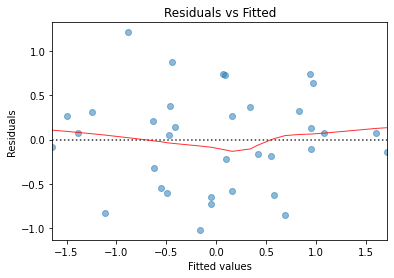

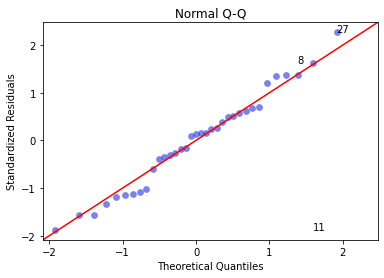

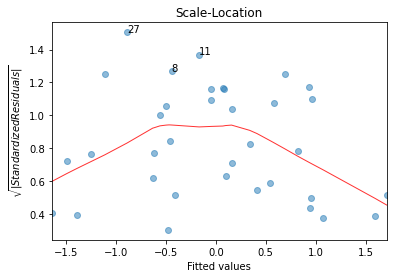

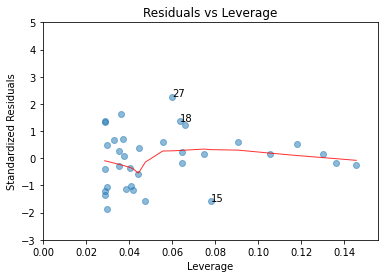

In [39]:
linear_plot = Plot.LinearRegressionResidualPlot(data_set_wConstant_parse_zca.values, y_train_ss_yj.values)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

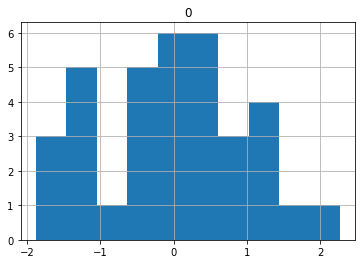

In [40]:
pd.DataFrame(results_parse.get_influence().resid_studentized_internal).hist()

In [41]:
print(ss_sortedFeatures)

['Population', 'Traf Deaths', 'Unemployed', 'Income', 'Infant Mort', 'White^2', 'White Population', 'White Traf Deaths', 'White Unemployed', 'White University', 'White Income', 'White Doctors', 'Population^2', 'Population Traf Deaths', 'Population Unemployed', 'Population Income', 'Population Infant Mort', 'Traf Deaths University', 'Unemployed^2', 'Unemployed Crime', 'Unemployed Income', 'Unemployed Infant Mort', 'University^2', 'University Income', 'University Doctors', 'Crime Doctors', 'Income Infant Mort', 'Income Doctors', 'Infant Mort^2', 'Infant Mort Doctors', 'Doctors^2']


In [42]:
#model = sklearn.linear_model.LinearRegression()
#data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
data_set_wConstant_ss_pca = statsmodels.tools.tools.add_constant(X_pca_train)
#y_ = data_set_wConstant[target]
#data_set_wConstant = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model_ss = sm.OLS(y_train_ss_yj,data_set_wConstant_ss_pca)
results_ss = model_ss.fit()
fitted = results_ss.predict(data_set_wConstant_ss_pca)
results_ss.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Poverty   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     8.281
Date:                Sat, 21 Aug 2021   Prob (F-statistic):           0.000106
Time:                        12:23:57   Log-Likelihood:                -5.0072
No. Observations:                  35   AIC:                             52.01
Df Residuals:                      14   BIC:                             84.68
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.714e-17      0.075   -1.3e-15      1.000      -0.160       0.160
0              0.0001      0.028      0.005      0.996      -0.061       0.061
1             -0.1103      0.033     -3.295      0.005      -0.182      -0.038
2             -0.0497      0.040     -1.232      0.238      -0.136       0.037
3             -0.2512      0.042     -6.020      0.000      -0.341      -0.162
4              0.3657      0.044      8.364      0.000       0.272       0.459
5             -0.0498      0.053     -0.936      0.365      -0.164       0.064
6              0.1268      0.055      2.289      0.038       0.008       0.246
7              0.2461      0.065      3.769      0.002       0.106       0.386
8             -0.0807      0.070     -1.160      0.266      -0.230       0.069
9              0.1524      0.073      2.084      0.056      -0.004       0.309
10             0.0522      0.076      0.686      0.504      -0.111       0.215
11            -0.2730      0.093     -2.924      0.011      -0.473      -0.073
12            -0.2169      0.097     -2.228      0.043      -0.426      -0.008
13            -0.0740      0.109     -0.676      0.510      -0.309       0.161
14            -0.0467      0.133     -0.351      0.731      -0.332       0.239
15            -0.2131      0.146     -1.459      0.167      -0.526       0.100
16            -0.0964      0.157     -0.615      0.548      -0.433       0.240
17            -0.0008      0.167     -0.005      0.996      -0.360       0.358
18             0.2034      0.220      0.926      0.370      -0.268       0.675
19             0.3947      0.224      1.761      0.100      -0.086       0.875
==============================================================================
Omnibus:                        2.974   Durbin-Watson:                   2.231
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                1.891
Skew:                           0.542   Prob(JB):                        0.389
Kurtosis:                       3.346   Cond. No.                         7.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

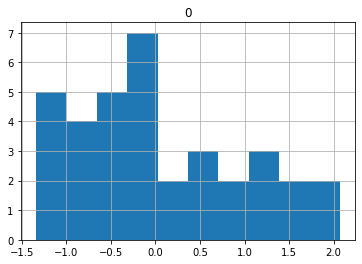

In [43]:
pd.DataFrame(results_ss.get_influence().resid_studentized_internal).hist()

Summary of Regression
:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     8.281
Date:                Sat, 21 Aug 2021   Prob (F-statistic):           0.000106
Time:                        12:23:58   Log-Likelihood:                -5.0072
No. Observations:                  35   AIC:                             52.01
Df Residuals:                      14   BIC:                             84.68
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.714e-17      0.

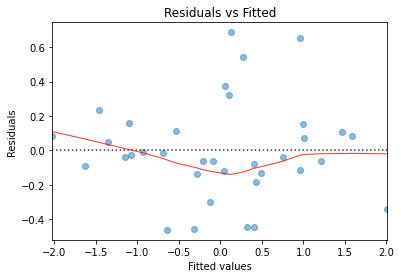

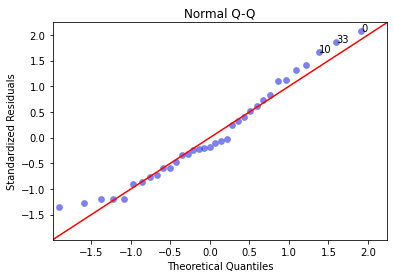

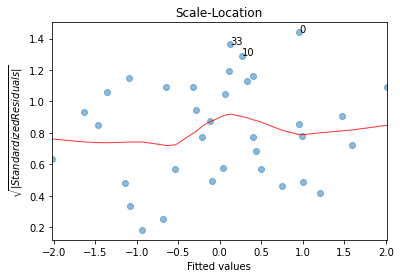

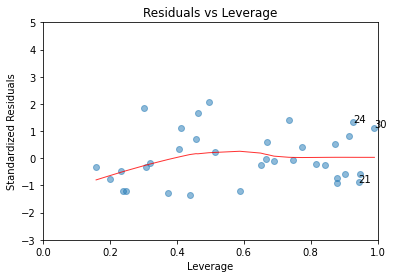

In [44]:
linear_plot = Plot.LinearRegressionResidualPlot(data_set_wConstant_ss_pca.values, y_train_ss_yj.values)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))


Mean Absolute Error
Poverty    1.828583
dtype: float64


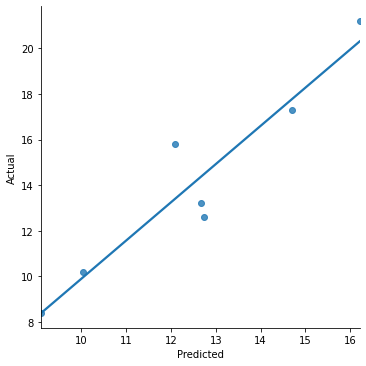

In [45]:
#ols parse
#uses ZCA
y_train_predicted = y_train_ss_yj_t.inverse_transform(pd.DataFrame(results_parse.fittedvalues,columns=[target]))

y_valid_ss_fitted_parse = y_train_ss_yj_t.inverse_transform(pd.DataFrame(results_parse.predict(sm.tools.tools.add_constant(zca.transform(x_valid_ss_yj_inter[ss_position_parse]), prepend=True, has_constant='skip')),index=x_valid_ss_yj_inter.index,columns=[target]))
# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid-y_valid_ss_fitted_parse)))

#temp = pd.concat([y_train_predicted,y_train_original],axis=1)
temp = pd.concat([y_valid_ss_fitted_parse,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

Mean Absolute Error
Poverty    1.462163
dtype: float64


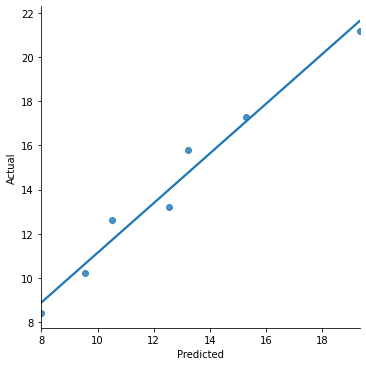

In [46]:
#ols best
#uses PCA
y_train_predicted = y_train_ss_yj_t.inverse_transform(pd.DataFrame(results_ss.fittedvalues,columns=[target]))

y_valid_ss_fitted = y_train_ss_yj_t.inverse_transform(pd.DataFrame(results_ss.predict(sm.tools.tools.add_constant(pca_X_train.transform(x_valid_ss_yj_inter[ss_sortedFeatures]), prepend=True, has_constant='skip')),index=x_valid_ss_yj_inter.index,columns=[target]))
# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid-y_valid_ss_fitted)))

#temp = pd.concat([y_train_predicted,y_train_original],axis=1)
temp = pd.concat([y_valid_ss_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

Mean Absolute Error
Poverty    2.007872
dtype: float64


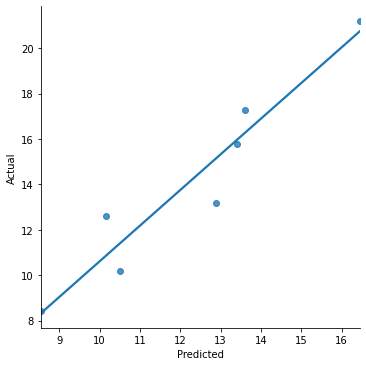

In [47]:
#EN Best

ENBestResults = model_eb.fit(x_train_ss_yj_inter[best['features']], y_train_ss_yj)

ENBestFitted = pd.DataFrame(model_eb.predict(x_train_ss_yj_inter[best['features']]),index=x_train_ss_yj_inter.index, columns = [target])

y_valid_eb_fitted = y_train_ss_yj_t.inverse_transform(pd.DataFrame(model_eb.predict(x_valid_ss_yj_inter[best['features']]),index=x_valid_ss_yj_inter.index,columns=[target]))

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_eb_fitted-y_valid)))

temp = pd.concat([y_valid_eb_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

Mean Absolute Error
Poverty    2.236041
dtype: float64


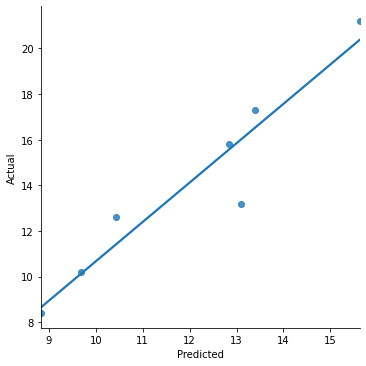

In [48]:
#EN Parse

ENParseResults = model_ep.fit(x_train_ss_yj_inter[parse['features']], y_train_ss_yj)

ENParseFitted = pd.DataFrame(model_ep.predict(x_train_ss_yj_inter[parse['features']]),index=x_train_ss_yj_inter.index,columns=[target])

y_valid_ep_fitted = y_train_ss_yj_t.inverse_transform(pd.DataFrame(model_ep.predict(x_valid_ss_yj_inter[parse['features']]),index=x_valid_ss_yj_inter.index,columns=[target]))

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_ep_fitted-y_valid)))

temp = pd.concat([y_valid_ep_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

Mean MAE: 1.690 (0.729)
Mean Absolute Error
Poverty    2.411946
dtype: float64


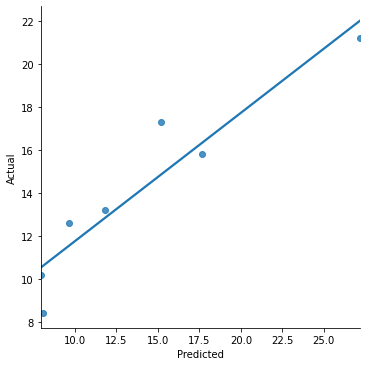

In [49]:
#robust regression using ols best
# define the model
model_rr_ss = RANSACRegressor()
# evaluate model
#Rresults_ss = evaluate_model(x_train_ss_yj_inter[ss_sortedFeatures], y_train_ss_yj, model_rr_ss)
Rresults_ss = evaluate_model(X_pca_train, y_train_ss_yj, model_rr_ss)

print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_ss), std(Rresults_ss)))
# plot the line of best fit
#Rresults_ss = model_rr_ss.fit(x_train_ss_yj_inter[ss_sortedFeatures],y_train_ss_yj)
Rresults_ss = model_rr_ss.fit(X_pca_train,y_train_ss_yj)
RFitted_ss = model_rr_ss.predict(pca_X_train.transform(x_train_ss_yj_inter[ss_sortedFeatures]))

y_valid_rr_ss_fitted_best = y_train_ss_yj_t.inverse_transform(pd.DataFrame(model_rr_ss.predict(pca_X_train.transform(x_valid_ss_yj_inter[ss_sortedFeatures])),index=x_valid_ss_yj_inter.index,columns=[target]))

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_rr_ss_fitted_best-y_valid)))

temp = pd.concat([y_valid_rr_ss_fitted_best,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);


Mean MAE: 0.511 (0.109)
Mean Absolute Error
Poverty    1.879814
dtype: float64


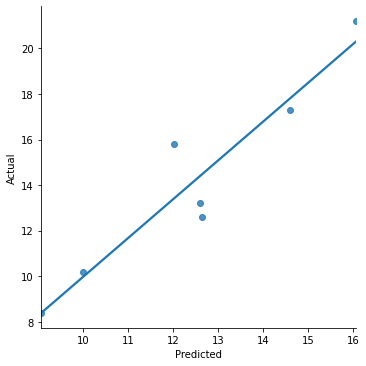

In [50]:
#robust regression using ols parse
# define the model
model_rr_ss = RANSACRegressor()
# evaluate model
#Rresults_ss = evaluate_model(x_train_ss_yj_inter[ss_sortedFeatures], y_train_ss_yj, model_rr_ss)
Rresults_ss = evaluate_model(data_set_wConstant_parse_zca, y_train_ss_yj, model_rr_ss)

print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_ss), std(Rresults_ss)))
# plot the line of best fit
#Rresults_ss = model_rr_ss.fit(x_train_ss_yj_inter[ss_sortedFeatures],y_train_ss_yj)
Rresults_ss = model_rr_ss.fit(data_set_wConstant_parse_zca,y_train_ss_yj)
#RFitted_ss = model_rr_ss.predict(data_set_wConstant_parse_zca)

y_valid_rr_ss_fitted_parse = y_train_ss_yj_t.inverse_transform(pd.DataFrame(Rresults_ss.predict(sm.tools.tools.add_constant(zca.transform(x_valid_ss_yj_inter[ss_position_parse]), prepend=True, has_constant='skip')),index=x_valid_ss_yj_inter.index,columns=[target]))

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_rr_ss_fitted_parse-y_valid)))

temp = pd.concat([y_valid_rr_ss_fitted_parse,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);


Mean MAE: 0.253 (0.077)
Mean Absolute Error
Poverty    1.939537
dtype: float64


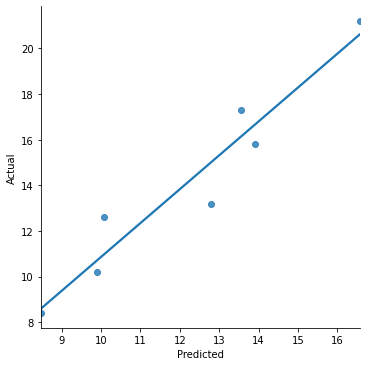

In [51]:
#robust regression using EN best
# define the model
model_rr_best = RANSACRegressor()
# evaluate model
Rresults_best = evaluate_model(x_train_ss_yj_inter[best['features']], y_train_ss_yj, model_rr_best)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_best), std(Rresults_best)))
# plot the line of best fit
Rresults_best = model_rr_best.fit(x_train_ss_yj_inter[best['features']],y_train_ss_yj)
RFitted_best = model_rr_best.predict(x_train_ss_yj_inter[best['features']])

y_valid_rr_en_best_fitted = y_train_ss_yj_t.inverse_transform(pd.DataFrame(model_rr_best.predict(x_valid_ss_yj_inter[best['features']]),index=x_valid_ss_yj_inter.index,columns=[target]))
# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_rr_en_best_fitted-y_valid)))

temp = pd.concat([y_valid_rr_en_best_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

Mean MAE: 0.313 (0.099)
Mean Absolute Error
Poverty    2.162879
dtype: float64


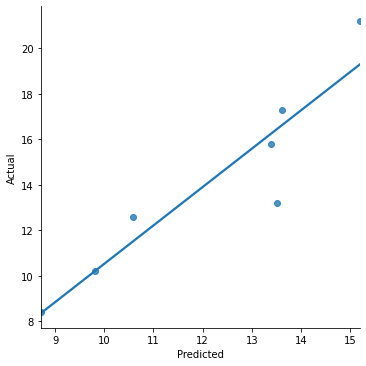

In [52]:
#robust regression using EN parse
# define the model
model_rr_parse = RANSACRegressor()
# evaluate model
Rresults_parse = evaluate_model(x_train_ss_yj_inter[best['features']], y_train_ss_yj, model_rr_parse)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_parse), std(Rresults_parse)))
# plot the line of best fit
Rresults_parse = model_rr_parse.fit(x_train_ss_yj_inter[parse['features']],y_train_ss_yj)
RFitted_parse = model_rr_parse.predict(x_train_ss_yj_inter[parse['features']])

y_valid_rr_en_parse_fitted = y_train_ss_yj_t.inverse_transform(pd.DataFrame(Rresults_parse.predict(x_valid_ss_yj_inter[parse['features']]),index=x_valid_ss_yj_inter.index,columns=[target]))

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_rr_en_parse_fitted-y_valid)))

temp = pd.concat([y_valid_rr_en_parse_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

In [53]:
print("OLS SS: " + str(mean(absolute(np.array(y_valid)-y_valid_ss_fitted))))
print("OLS parse: " + str(mean(absolute(np.array(y_valid)-y_valid_ss_fitted_parse))))

print("EN best: " + str(mean(absolute(np.array(y_valid)-y_valid_eb_fitted))))
print("EN parse: " + str(mean(absolute(np.array(y_valid)-y_valid_ep_fitted))))

print("RR SS-best: " + str(mean(absolute(np.array(y_valid)-y_valid_rr_ss_fitted_best))))
print("RR SS-parse: " + str(mean(absolute(np.array(y_valid)-y_valid_rr_ss_fitted_parse))))

print("RR best: " + str(mean(absolute(np.array(y_valid)-y_valid_rr_en_best_fitted))))
print("RR parse: " + str(mean(absolute(np.array(y_valid)-y_valid_rr_en_parse_fitted))))

OLS SS: Poverty    1.462163
dtype: float64
OLS parse: Poverty    1.828583
dtype: float64
EN best: Poverty    2.007872
dtype: float64
EN parse: Poverty    2.236041
dtype: float64
RR SS-best: Poverty    2.411946
dtype: float64
RR SS-parse: Poverty    1.879814
dtype: float64
RR best: Poverty    1.939537
dtype: float64
RR parse: Poverty    2.162879
dtype: float64


In [54]:
#print("RR parse: " + str(mean(absolute(np.array(y)-RFitted_parse_all))))
#print("RR ss: " + str(mean(absolute(np.array(y)-RFitted_ss_all))))